(line)=

# Fitting a model to data

If you're reading this right now then you're probably interested in using
emcee to fit a model to some noisy data.
On this page, I'll demonstrate how you might do this in the simplest
non-trivial model that I could think of: fitting a line to data when you
don't believe the error bars on your data.
The interested reader should check out [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686) for a much more complete discussion of how
to fit a line to data in The Real World™ and why MCMC might come in handy.

In [71]:
import emcee
import corner

In [72]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

## The generative probabilistic model

When you approach a new problem, the first step is generally to write down the
*likelihood function* (the probability of a dataset given the model
parameters).
This is equivalent to describing the generative procedure for the data.
In this case, we're going to consider a linear model where the quoted
uncertainties are underestimated by a constant fractional amount.
You can generate a synthetic dataset from this model:

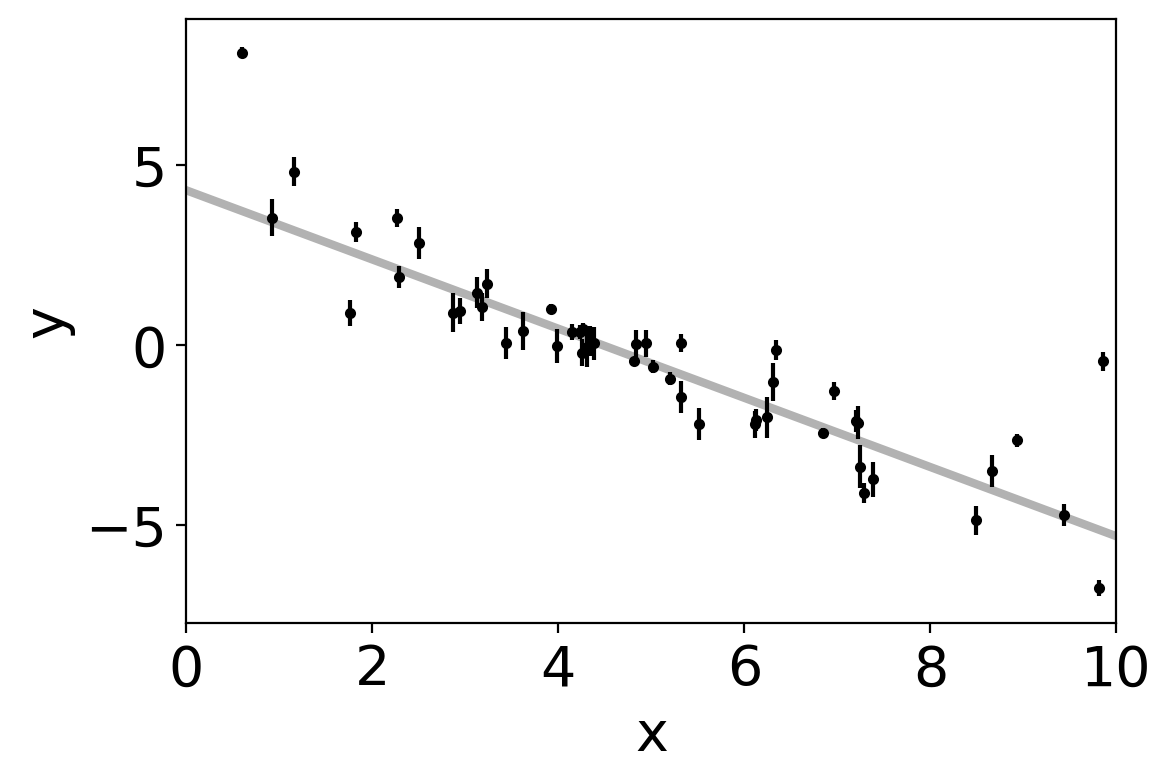

In [73]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


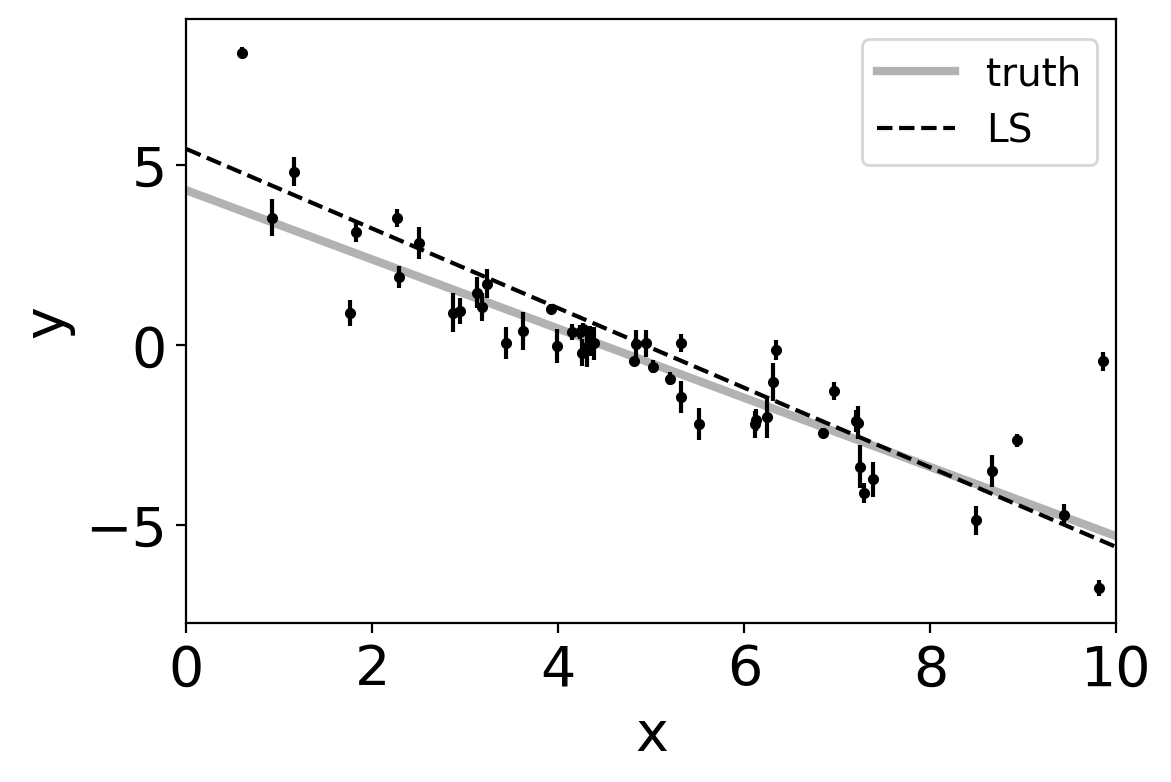

In [74]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [132]:
def straight_line(x, m, c):

    return m * x + c

In [181]:
Nens = 100   # number of ensemble points

mmin = -5     # mean of the Gaussian prior
mmax = 5. # standard deviation of the Gaussian prior

mini = np.random.uniform(mmin, mmax, Nens) # initial m points m= slpoe

cmin = 0.  # lower range of prior
cmax = 10.   # upper range of prior


cini = np.random.uniform(cmin, cmax, Nens) # initial c points

log_fmin = -10
log_fmax = 1

log_f = np.random.uniform(log_fmin, log_fmax, Nens)

inisamples = np.array([mini, cini, log_f]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions\

pos = np.array([mini, cini, log_f]).T


Nsamples = 5000
Nburnin = 500

In [183]:
def logprior(theta):
    m, b, log_f = theta
    if mmin < m < mmax and cmin < b < cmax and log_fmin < log_f < log_fmax:
        return 0.0
    return -np.inf

In [184]:
def log_prior(theta):
    m, b, log_f = theta
    if mmin < m < mmax and cmin < b < cmax and log_fmin < log_f < log_fmax:
        return 0.0
    return -np.inf
# Then, combining this with the definition of log_likelihood from above, the full log-probability function is:

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [185]:
def loglikelihood(theta, data, sigma, x):
    """
    The natural logarithm of the joint Gaussian likelihood.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined

    Note:
        We do not include the normalisation constants (as discussed above).
    """
    
    # unpack the model parameters from the tuple
    m, c ,logf = theta

    # evaluate the model (assumes that the straight_line model is defined as above)
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5 * np.sum(((md - data) / sigma)**2)


In [136]:
def logposterior(theta, data, sigma, x):
    """
    The natural logarithm of the joint posterior.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined
    """

    lp = logprior(theta) # get the prior

    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf

    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + loglikelihood(theta, data, sigma, x)

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

In [174]:
import emcee # import the emcee package

# for bookkeeping set number of likelihood calls to zero
loglikelihood.ncalls = 0

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (y, yerr, x)

# set up the sampler
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

In [175]:
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples + Nburnin);
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.get_chain(flat=True, discard=Nburnin)

/home/darkwake/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Time taken to run 'emcee' is 5.851806163787842 seconds


In [176]:
flat_samples = sampler.get_chain(discard=Nburnin, thin=15, flat=True)
print(flat_samples.shape)

(33300, 3)


In [177]:
from time import time
import matplotlib as mpl

In [178]:
samples_emcee = sampler.get_chain(flat=True, discard=Nburnin)

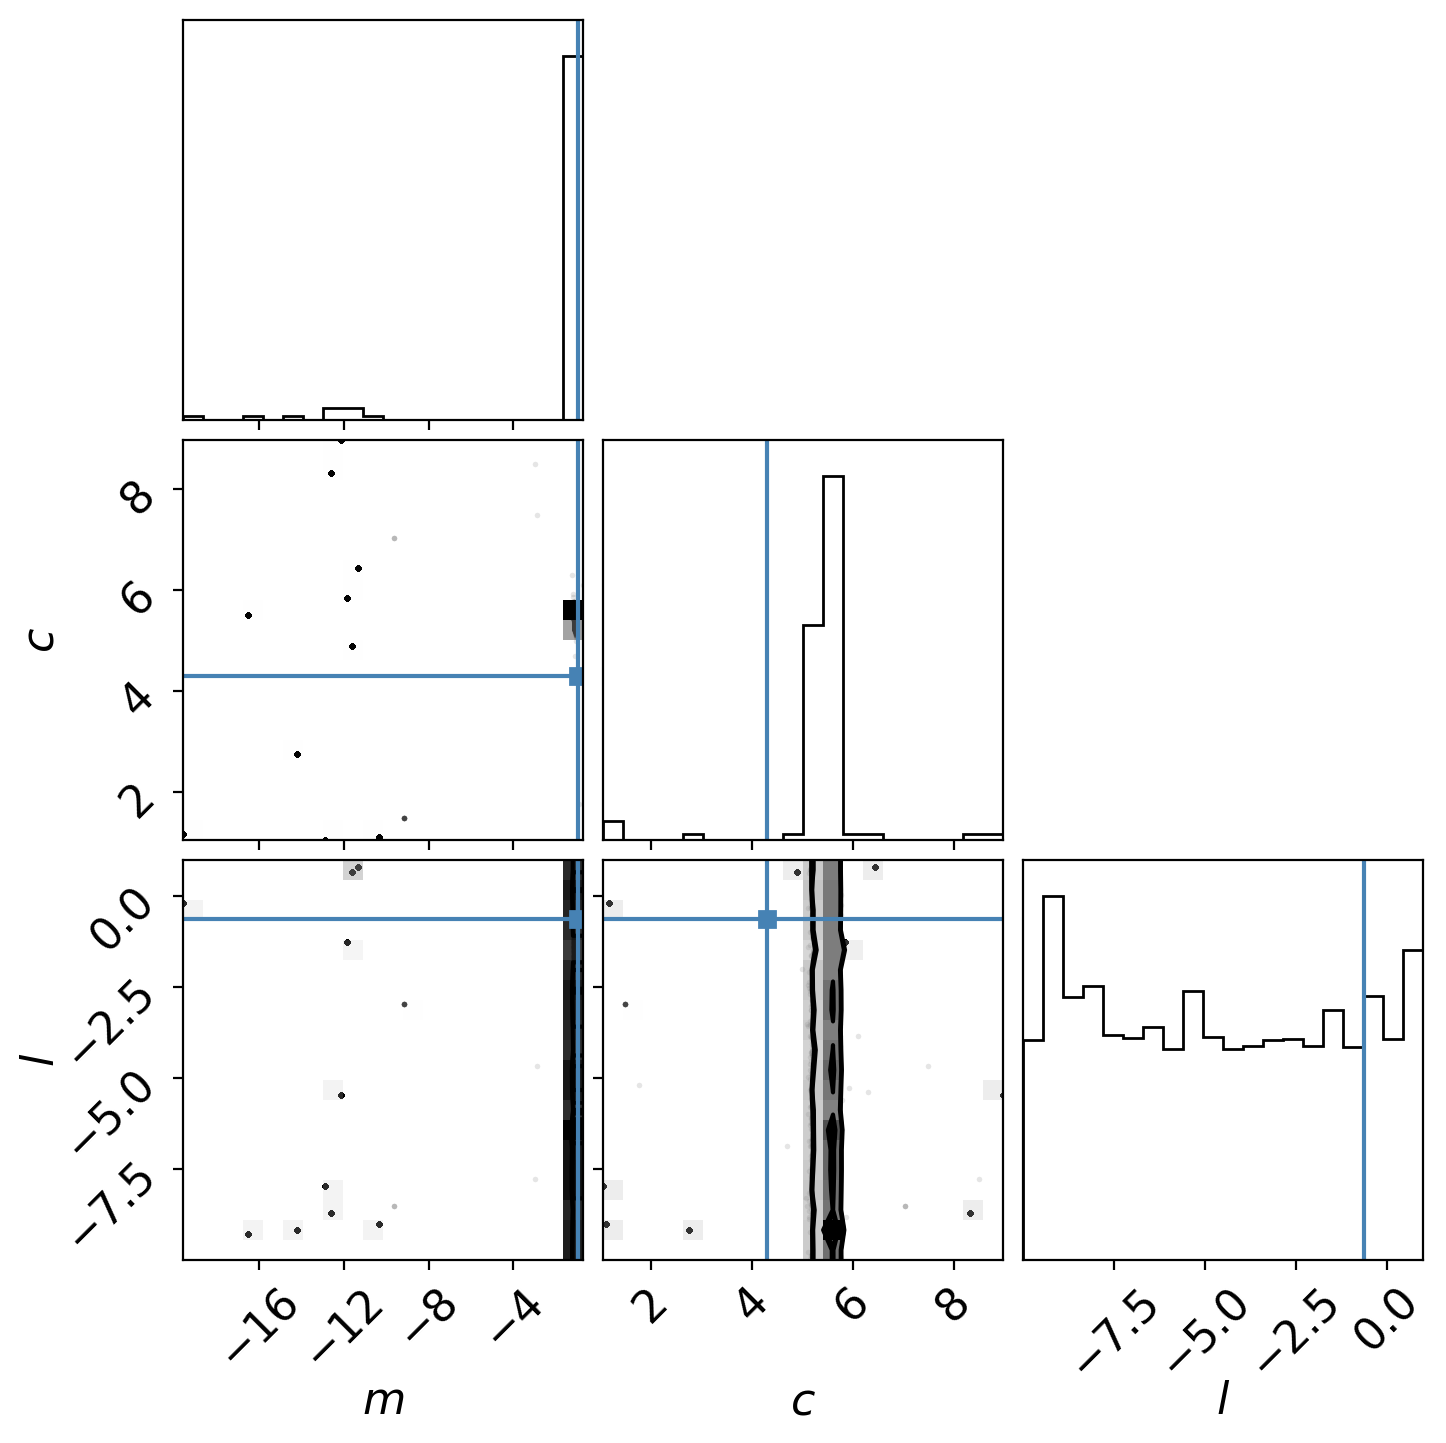

In [179]:
import corner

fig = corner.corner(
    flat_samples, labels=[r'$m$', r'$c$', r'$l$'], truths=[m_true, b_true, np.log(f_true)]);

ValueError: Provided figure has 4 axes, but data has dimensions K=3

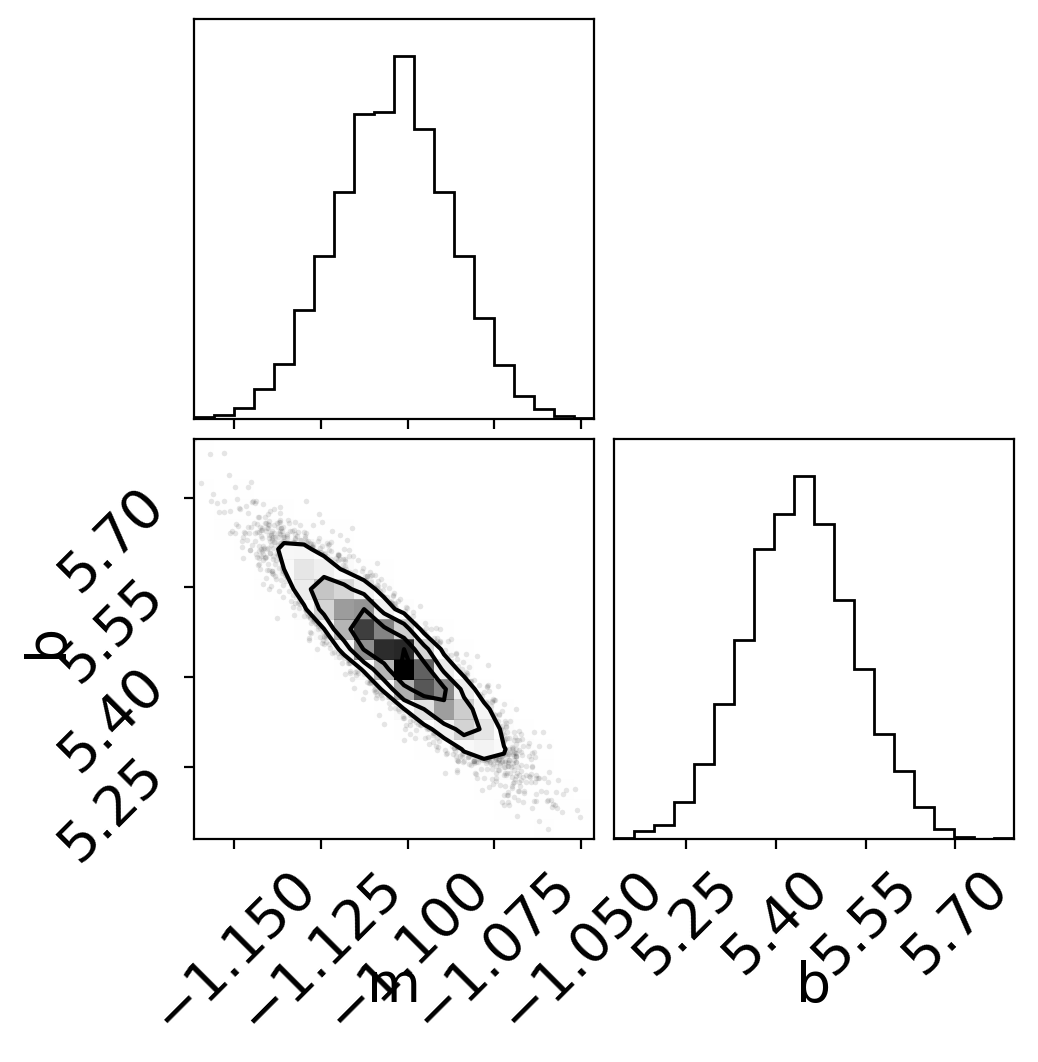

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

The corner plot shows all the one and two dimensional projections of the
posterior probability distributions of your parameters.
This is useful because it quickly demonstrates all of the covariances between
parameters.
Also, the way that you find the marginalized distribution for a parameter or
set of parameters using the results of the MCMC chain is to project the
samples into that plane and then make an N-dimensional histogram.
That means that the corner plot shows the marginalized distribution for each
parameter independently in the histograms along the diagonal and then the
marginalized two dimensional distributions in the other panels.

Another diagnostic plot is the projection of your results into the space of
the observed data.
To do this, you can choose a few (say 100 in this case) samples from the chain
and plot them on top of the data points:

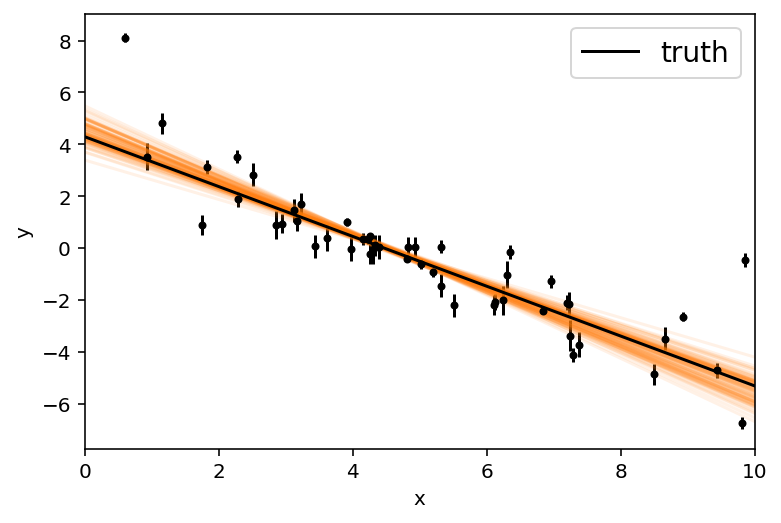

In [13]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

This leaves us with one question: which numbers should go in the abstract?
There are a few different options for this but my favorite is to quote the
uncertainties based on the 16th, 50th, and 84th percentiles of the samples in
the marginalized distributions.
To compute these numbers for this example, you would run:

In [14]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>